<img src="https://raw.githubusercontent.com/MLMI2-CSSI/foundry/main/assets/foundry-black.png" width=450>

# Foundry PACBED-CNN Tutorial for Beginners

Oberaigner M. et. al. Online Thickness Determination with Position Averaged Convergent Beam Electron Diffraction using Convolutional Neural Networks, Microscopy and Microanalysis, Volume 29, Issue 1, February 2023, Pages 427–436, https://doi.org/10.1093/micmic/ozac050

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MLMI2-CSSI/foundry/blob/main/examples/PACBEDCNN-thickness-mistilt/PACBEDCNN_thickness_mistilt.ipynb)

This introduction uses Foundry to:


1. Load a predictive model from Foundry
2. infer sample thickness and mistilt angle from an example PACBED image using the model
This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run.

In [1]:
try:
    import google.colab
    no_local_server=True
    no_browser=True
    globus=False
except: # when not in google colab
    no_local_server=False
    no_browser=False
    globus=True

# Installing Foundry


In [2]:
!pip install foundry_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.5/217.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.5/111.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.3.3
    Uninstalling jsonschema-4.3.3:
      Successfully uninstalled jsonschema-4.3.3


In [3]:
from foundry import Foundry

# Instantiating Foundry
To instantiate Foundry, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code.


In [4]:
f = Foundry(index="mdf", no_local_server=no_local_server, no_browser=no_browser)

Please paste the following URL in a browser:
https://auth.globus.org/v2/oauth2/authorize?client_id=984464e2-90ab-433d-8145-ac0215d26c8e&redirect_uri=https%3A%2F%2Fauth.globus.org%2Fv2%2Fweb%2Fauth-code&scope=urn%3Aglobus%3Aauth%3Ascope%3Adata.materialsdatafacility.org%3Aall+https%3A%2F%2Fauth.globus.org%2Fscopes%2Fc17f27bb-f200-486a-b785-2a25e82af505%2Fconnect+urn%3Aglobus%3Aauth%3Ascope%3Asearch.api.globus.org%3Asearch+https%3A%2F%2Fauth.globus.org%2Fscopes%2F56ceac29-e98a-440a-a594-b41e7a084b62%2Fall+urn%3Aglobus%3Aauth%3Ascope%3Atransfer.api.globus.org%3Aall+https%3A%2F%2Fauth.globus.org%2Fscopes%2F81fc4156-a623-47f2-93ad-7184118226ba%2Fauth+openid+https%3A%2F%2Fauth.globus.org%2Fscopes%2Ffacd7ccc-c5f4-42aa-916b-a0e270e2c2a9%2Fall+https%3A%2F%2Fauth.globus.org%2Fscopes%2Ff10a69a9-338c-4e5b-baa1-0dc92359ab47%2Fhttps+https%3A%2F%2Fauth.globus.org%2Fscopes%2F82f1b5c6-6e9b-11e5-ba47-22000b92c6ec%2Fhttps+https%3A%2F%2Fauth.globus.org%2Fscopes%2Fd31d4f5d-be37-4adc-a761-2f716b7af105%2Facti

# Prepare the input dictionary


The pretrained models are trained on specific types of crystal lattice and zone axis as well as accelaration voltage. Thus the avalible sets of experimental parameters are: 

- 300.0 kV, zone 001, 'Strontium Titanate'
- 80.0 kV, zone 001, 'Rutile'


In [22]:
# Download the example input data
!wget https://github.com/wdwzyyg/foundry/raw/example_notebooks/examples/PACBEDCNN-thickness-mistilt/STO_PACBED.npy

--2023-05-28 19:49:17--  https://github.com/wdwzyyg/foundry/raw/example_notebooks/examples/PACBEDCNN-thickness-mistilt/STO_PACBED.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wdwzyyg/foundry/example_notebooks/examples/PACBEDCNN-thickness-mistilt/STO_PACBED.npy [following]
--2023-05-28 19:49:17--  https://raw.githubusercontent.com/wdwzyyg/foundry/example_notebooks/examples/PACBEDCNN-thickness-mistilt/STO_PACBED.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131200 (128K) [application/octet-stream]
Saving to: ‘STO_PACBED.npy’

STO_PACBED.npy      100%[===================>] 128.12K  --.

In [23]:
import os
import numpy as np
root = os.getcwd()
pacbed = np.load(root + '/STO_PACBED.npy', allow_pickle=False)


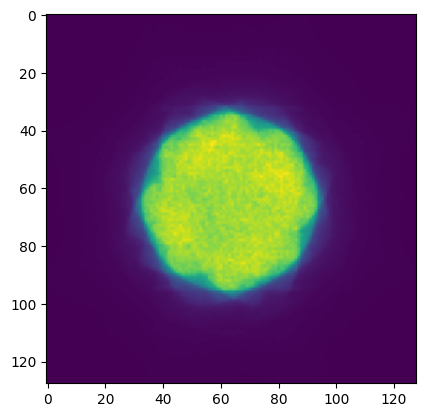

In [24]:
import matplotlib.pyplot as plt
plt.imshow(pacbed)

In [25]:
import numpy as np
inputd = {'pacbed':pacbed,
         'acceleration_voltage_kV':300.0,
         'zone_u':0,
         'zone_v':0,
         'zone_w':1,
         'crystal_structure':'Strontium Titanate',
         'convergence_angle_mrad':23.4
         }
# only 300.0 kV, 001 'Strontium Titanate' and 80.0 kV, 001 'Rutile'


# Run prediction

In [26]:
result = f.run("jwei74_wisc/PACBEDCNN_thickness_mistilt", inputd)

# Check the results

In [27]:
result

{'thickness_pred': 140,
 'thickness_cnn_output': array([[8.88610354e-18, 4.51859678e-15, 2.93937487e-12, 4.48952611e-11,
         5.46138723e-14, 1.43366091e-19, 2.18791191e-22, 3.31289939e-20,
         1.02308748e-19, 7.30808695e-18, 4.34686183e-18, 4.21731956e-18,
         6.44402920e-10, 5.88960247e-03, 9.90149617e-01, 3.96082457e-03,
         4.28270787e-12, 6.98505366e-20, 8.81938351e-23, 2.12353349e-24,
         1.23749781e-25, 1.41041841e-24, 1.10504363e-21, 4.85310464e-18,
         1.87839879e-17, 1.16713927e-16, 1.60969863e-16, 4.78582244e-16,
         1.31404260e-13, 7.45618592e-16, 1.29263724e-20, 4.84334445e-24,
         2.48824676e-24, 6.69148660e-24, 7.33058445e-20, 2.95751691e-16,
         1.03409468e-13, 1.22512688e-12, 9.06326472e-11, 1.71250340e-11,
         2.29431844e-13, 3.69597067e-15, 1.66922963e-17, 1.66758061e-18,
         2.64124884e-16, 1.11558534e-14, 3.56192728e-15, 4.14445379e-17,
         1.10158558e-18, 3.15942049e-19, 5.78032560e-21, 4.14408343e-20,
   

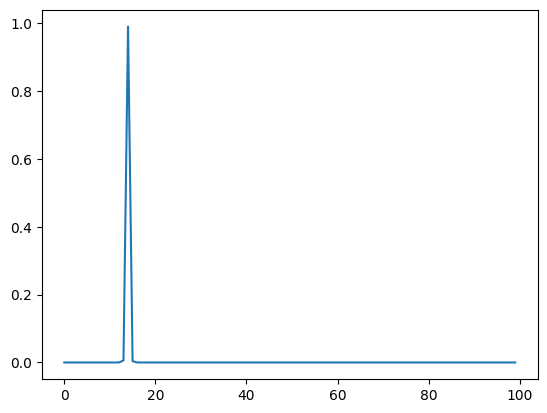

In [28]:
t = result['thickness_cnn_output']

plt.plot(np.arange(t.shape[1]), t[0])